# Home Credit Default Risk by Kaggle

Inspired by the classic Kaggle problem: [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/overview), we are creating an ultimate cheatsheet for data scientist interviews. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

set_config(transform_output="pandas") 

In [2]:
raw_data = pd.read_csv("data/application_train.csv")

df = raw_data.copy()
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# 1. Check the target column

In [3]:
# 1. Check target value
df.groupby("TARGET").size()

TARGET
0    282686
1     24825
dtype: int64

In [4]:
df.drop(columns = ["TARGET", "SK_ID_CURR"], inplace=True)
trans_values = {}
col_transformers = []

This is a very **imbalanced data**, with label 1 less than 10% of label 0.
The way we usually handle imbalance data:

a) Data level:
Collect more data in minority class  
Undersample: might remove important data  
Oversample: might overfit  
To mitigate:   
Two-phase learning: train on resampled data, fine tune on original data  
Dynamic sampling: oversample the low-performing class and undersample the high performing class during training.  

b) Metric level: Check precision/recall, f1, AUC in ROC curve

c) Algorithm level: Add stronger penalty on misclassifying the minority class in loss function

# 2. Check predictors


2.0 Check the dtypes of predictors  
2.1 Check if all the numeric binary columns are in [0, 1]  
2.2 Check outliers in non-binary numeric cols, and impute them with null, medium or mean

In [5]:
# 2. Check the predictors
df.dtypes.value_counts()

float64    65
int64      39
object     16
dtype: int64

In [6]:
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols = [_ for _ in num_cols if _ not in ["SK_ID_CURR", "TARGET"]]
print(len(num_cols))

104


In [7]:
num_cols_nonbinary = [x for x in num_cols if all(words not in x for words in ["FLAG", "NOT"])]
print(len(num_cols_nonbinary))
num_cols_binary = [_ for _ in num_cols if _ not in num_cols_nonbinary]
print(len(num_cols_binary))

72
32


In [8]:
# 2.1 Check if all the numeric binary columns are either 0 or 1
invalid_cols = df[num_cols_binary].columns[~df[num_cols_binary].isin([0,1]).all()]
print(invalid_cols)
# Looks good!

Index([], dtype='object')


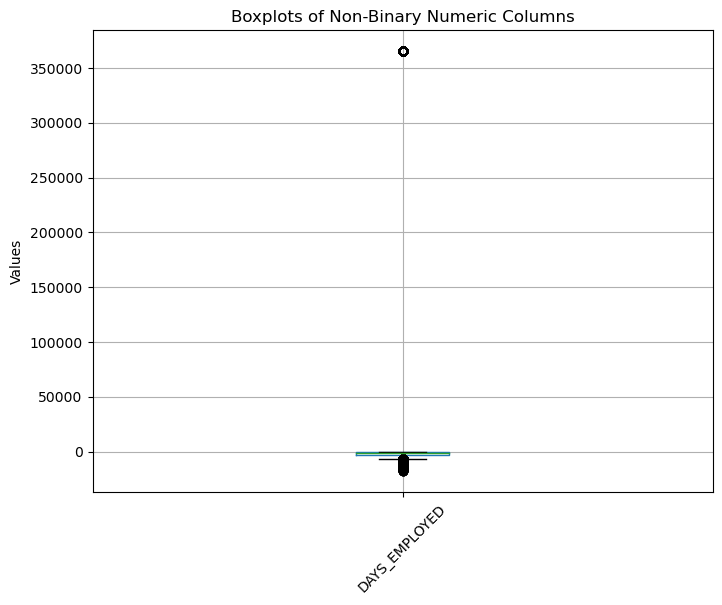

In [9]:
# 2.2 Check outliers on non-binary numeric cols

# Plot boxplots for the specified columns
plt.figure(figsize=(8, 6))
df[["DAYS_EMPLOYED"]].boxplot()
plt.title("Boxplots of Non-Binary Numeric Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

**How to deal with outliers?**

1. Remove the row
2. Impute with mean/medium/null value

In [10]:
# Drop the row
# index = df.loc[df['DAYS_EMPLOYED'].isna(), :].index
# df.drop(index, axis=0, inplace=True)


In [11]:
df["DAYS_EMPLOYED"].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [12]:
# Impute with null value
DAYS_EMPLOYED_UPPER = df['DAYS_EMPLOYED'].quantile(0.99)
print("DAYS_EMPLOYED_UPPER: ", DAYS_EMPLOYED_UPPER)

trans_values.update({'DAYS_EMPLOYED_UPPER': DAYS_EMPLOYED_UPPER})

# df.loc[df['DAYS_EMPLOYED'] >= DAYS_EMPLOYED_UPPER, 'DAYS_EMPLOYED'] = np.nan
# df.loc[df['DAYS_EMPLOYED'] > trans_values['DAYS_EMPLOYED_UPPER'], "DAYS_EMPLOYED"] = np.nan

DAYS_EMPLOYED_UPPER:  365243.0


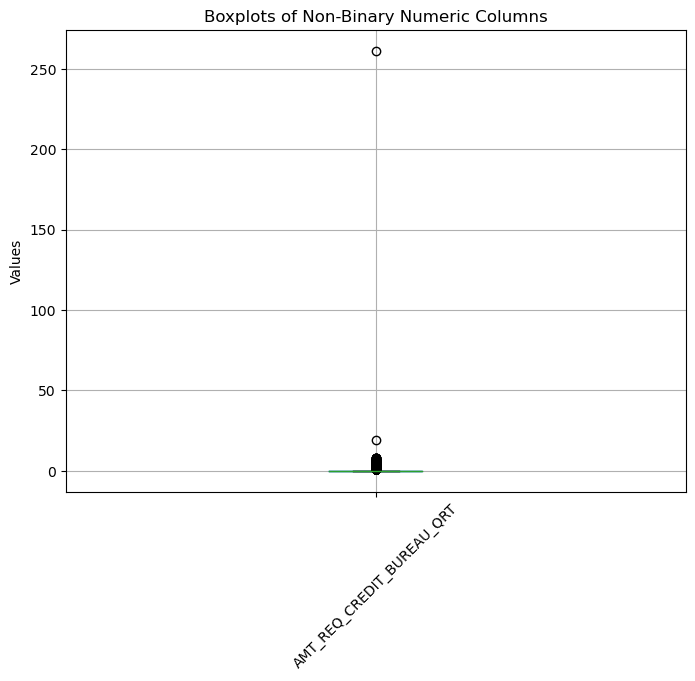

In [13]:
# Plot boxplots for the specified columns
plt.figure(figsize=(8, 6))
df[["AMT_REQ_CREDIT_BUREAU_QRT"]].boxplot()
plt.title("Boxplots of Non-Binary Numeric Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

In [14]:
df['AMT_REQ_CREDIT_BUREAU_QRT'].describe()

count    265992.000000
mean          0.265474
std           0.794056
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         261.000000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

In [15]:
# Impute with median

AMT_REQ_CREDIT_BUREAU_QRT_UPPER = 260 # From the plot
print("AMT_REQ_CREDIT_BUREAU_QRT_UPPER:  ", AMT_REQ_CREDIT_BUREAU_QRT_UPPER)

AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN = df['AMT_REQ_CREDIT_BUREAU_QRT'].median()
print("AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN: ", AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN)


trans_values.update({'AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN': AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN,
                     'AMT_REQ_CREDIT_BUREAU_QRT_UPPER': AMT_REQ_CREDIT_BUREAU_QRT_UPPER
                    }
                   )

# df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > AMT_REQ_CREDIT_BUREAU_QRT_UPPER,'AMT_REQ_CREDIT_BUREAU_QRT'] = df['AMT_REQ_CREDIT_BUREAU_QRT'].median()

AMT_REQ_CREDIT_BUREAU_QRT_UPPER:   260
AMT_REQ_CREDIT_BUREAU_QRT_MEDIAN:  0.0


**Note!** In real-life ML practice, we always use the **training data only** for imputation or outlier detection. We can not foresee the stats of future unseen data in practice, and using test data would cause data leakage.  
In a Kaggle competition, however, we use train+test stats as it generally improves leaderboard score, but it won't generalize well outside the leaderboard.  
This notebook is for data scientist interview prep, so we always stick to real-life practice. The stats from training data are stored in a dictionary and will be applied to test data later.




# 3. Missing values in predictors

**Tree-based models**, like XGBoost, can handle missing values and no need to inpute.  
**Distance-based models**, linear Regression, SVM, KNN, Neural networks need imputation.


## 3.1 Impute Categorical Variables

If missing values < 5%:  impute with the mode.  
If missing values >= 5%:  impute with a new category in "Unknown" to indicate the value is missing


In [16]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols_missing_pct = df[cat_cols].isnull().sum()/df.shape[0]

In [17]:
# mising value percentage <= 5% -> most frequest
missing_minor_cols = cat_cols_missing_pct[(cat_cols_missing_pct <= 0.05) & (cat_cols_missing_pct > 0)].index.to_list()
df[missing_minor_cols].value_counts(dropna= False)

print("There are {} categorical columns with less than 5% missing vals: {}".format(len(missing_minor_cols), missing_minor_cols))




There are 1 categorical columns with less than 5% missing vals: ['NAME_TYPE_SUITE']


In [18]:
# mising value percentage > 5% -> "Unknown"
missing_major_cols = cat_cols_missing_pct[cat_cols_missing_pct > 0.05].index.to_list()
print("There are {} categorical columns with over 5% missing vals: {}".format(len(missing_major_cols), missing_major_cols))

There are 5 categorical columns with over 5% missing vals: ['OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


## 3.2 Impute Numeric Variables


If missing values < 5%:  impute with the median.  
If missing values >= 5%:  impute with mean + missing flag column

In [19]:
num_cols_missing_pct = df[num_cols].isnull().sum()/df.shape[0]


In [20]:
num_cols_missing_minor_cols = num_cols_missing_pct[num_cols_missing_pct <=0.05].index.to_list()
print("There are {} numeric columns with less than 5% missing vals: {}".format(len(num_cols_missing_minor_cols), num_cols_missing_minor_cols))



# col_transformers.append(transform_minor_num_columns_pipe)

num_cols_missing_major_cols = num_cols_missing_pct[num_cols_missing_pct > 0.05].index.to_list()
print("There are {} numeric columns with over 5% missing vals: {}".format(len(num_cols_missing_major_cols), num_cols_missing_major_cols))



There are 52 numeric columns with less than 5% missing vals: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13

# 4. Feature Engineering

## 4.1 One-hot vector

In real pipeline, we use SimpleImputer to avoid dataleakage.

# Modeling

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve
from outlier_and_nan_imputer import OutlierAndNaNImputer



In [22]:
# Prepare features

Y = raw_data["TARGET"]
X_cols = [_ for _ in df.columns if _ not in ["TARGET", "SK_ID_CURR"]]
X = df[X_cols]


DAYS_EMPLOYED and AMT_REQ_CREDIT_BUREAU_QRT need special treatment:

DAYS_EMPLOYED:
1. Identify values > 0.99 quantile as outliers, and impute with median.
2. Impute missing values with mean.

AMT_REQ_CREDIT_BUREAU_QRT:
1. Identify values > 260 as outliers, and impute with median.
2. Impute missing values with mean.

In [23]:
days_emp_pipe = Pipeline([
    ("days_employed", OutlierAndNaNImputer(q=0.99))
])

    
amt_req_qtr_pipe = Pipeline([
    ("imp", OutlierAndNaNImputer(upper=260))
])

In [24]:
# Other column transformers
num_cols_missing_major_cols = [_ for _ in num_cols_missing_major_cols if _ not in ("DAYS_EMPLOYED", "AMT_REQ_CREDIT_BUREAU_QRT")]



num_minor_pipe = Pipeline([
    ("num_minor", SimpleImputer(strategy = "median")),
]
)

num_major_pipe = Pipeline([
    ("num_major", SimpleImputer(strategy = "mean", add_indicator=True)),
]
)


cat_minor_pipe = Pipeline([
    ("cat_minor", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
]
)


cat_major_pipe = Pipeline([
    ("cat_major", SimpleImputer(strategy="constant", fill_value = "Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
]
)


other_cat_cols = [_ for _ in cat_cols if (_ not in missing_minor_cols) and (_ not in missing_major_cols)]
other_cat_cols_pipline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]
)


col_transformers = [
    ("days_emp", days_emp_pipe, ["DAYS_EMPLOYED"]),
    ("amt_req_qtr", amt_req_qtr_pipe, ["AMT_REQ_CREDIT_BUREAU_QRT"]),
    ("num_minor", num_minor_pipe, num_cols_missing_minor_cols),
    ("num_major", num_major_pipe, num_cols_missing_major_cols),
    ("cat_minor", cat_minor_pipe, missing_minor_cols),
    ("cat_major", cat_major_pipe, missing_major_cols),
    ("other_cat", other_cat_cols_pipline, other_cat_cols)
    
]

In [25]:
# Create column transformer
preprocessor = ColumnTransformer(transformers= col_transformers, remainder="passthrough" )#.set_output(transform="pandas") 

df_cleaned = preprocessor.fit_transform(X)

df_cleaned.head()

df_cleaned = pd.DataFrame(
    df_cleaned,
    columns=preprocessor.get_feature_names_out(),
    index=df.index
)
df_cleaned.columns = [c.split("__")[-1] for c in df_cleaned.columns]

df_cleaned.head()

,DAYS_EMPLOYED,AMT_REQ_CREDIT_BUREAU_QRT,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,-637.0,0.000000,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1188.0,0.000000,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-225.0,0.000000,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3039.0,0.264494,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3038.0,0.000000,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:


# Check missing values
cols_missing_pct = df_cleaned.isnull().sum()/df_cleaned.shape[0]
cols_missing_pct[cols_missing_pct> 0].index

Index([], dtype='object')

In [27]:
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned, Y,test_size=0.2, random_state=0)

In [29]:
class_weight = [
    "balanced",
]

c = np.linspace(0.01, 0.1, 1, 10)
penalty = ['l1', 'l2']

hyperparameters = dict(C=c, class_weight=class_weight, penalty=penalty)

lr = LogisticRegression(solver='liblinear', random_state=0)

grid = GridSearchCV(
    lr,
    hyperparameters,
    scoring=make_scorer(roc_auc_score, needs_proba=True),
    cv=3,
    n_jobs=-1,
    verbose=10
)

best_param = grid.fit(X_train, y_train)
print("Best params:", best_param.best_params_)
print("Best AUC:", best_param.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}
Best AUC: 0.7459394118125083


In [30]:
#Testing scores, confusion matrix
def model_performance(y_test,y_pred,y_pred_pr):
    print("f1_score: ", f1_score(y_test, y_pred))
    print("confusion matrix", confusion_matrix(y_test,y_pred))
    print("roc_auc_score: ", roc_auc_score(y_test,y_pred_pr))
    
#print result, draw bar graph for feature importance for non-pca method
def print_result(model,x_test):
    print(model)
    feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=x_test.columns)
    feat_importances.nlargest(15).plot(kind='barh')
    return pd.DataFrame(model.cv_results_)



y_pred = best_param.predict(X_test)
y_pred_prob = best_param.predict_proba(X_test)[:, 1]
model_performance(y_test, y_pred, y_pred_prob)

f1_score:  0.2549773233914982
confusion matrix [[38802 17846]
 [ 1538  3317]]
roc_auc_score:  0.7479883759370567


The roc-auc score is fine but f1-score is low. One possible reason is the default threshold 0.5 didn't cutoff properly.

In [31]:
prec, rec, thresh = precision_recall_curve(y_pred, y_pred_prob)

# Compute F1 for each threshold
f1_scores = 2 * prec * rec / (prec + rec)
best_idx = f1_scores.argmax()
print("Best threshold:", thresh[best_idx])
print("Best F1:", f1_scores[best_idx])

Best threshold: 0.5000319257023318
Best F1: 1.0


In [32]:
# prec, rec, thr = precision_recall_curve(y_pred, y_pred_prob)

# f1_vals = 2 * prec * rec / (prec + rec)
# f1_vals = np.nan_to_num(f1_vals, nan=0.0)  # guard against 0/0

# # Align lengths: drop the first F1 (no threshold)
# f1_aligned = f1_vals[:-1]
# best_idx = f1_aligned.argmax()
# best_threshold = thr[best_idx]
# best_f1 = f1_aligned[best_idx]

# print("Best threshold:", best_threshold)
# print("Best F1:", best_f1)

# # (Optional) verify by applying the threshold
# y_pred = (pred_logit_pr >= best_threshold).astype(int)
# print("F1 at best threshold (recomputed):", f1_score(y_test, y_pred))

# Submit

In [33]:
raw_test_data = pd.read_csv("data/application_test.csv")


In [35]:
# Impute missing values
# preprocessor = ColumnTransformer(transformers= col_transformers, remainder="passthrough" ).set_output(transform="pandas")
test_df = raw_test_data[[_ for _ in raw_test_data.columns if _!= "SK_ID_CURR"]]

test_df_imputed = preprocessor.transform(test_df)

test_df_imputed = pd.DataFrame(
    test_df_imputed,
    columns=preprocessor.get_feature_names_out(),
    index=test_df.index
)
test_df_imputed.columns = [c.split("__")[-1] for c in test_df_imputed.columns]

test_df_imputed.head()

,DAYS_EMPLOYED,AMT_REQ_CREDIT_BUREAU_QRT,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,-2329.0,0.000000,0.0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241.0,-2329.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-4469.0,0.000000,0.0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064.0,-4469.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-4458.0,1.000000,0.0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038.0,-4458.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1866.0,0.000000,2.0,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976.0,-1866.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2191.0,0.264494,1.0,180000.0,625500.0,32067.0,625500.0,0.010032,-13040.0,-2191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
test_y_pred = best_param.predict(test_df_imputed)
test_y_pred_prob = best_param.predict_proba(test_df_imputed)[:, 1]


final = pd.DataFrame(raw_test_data[["SK_ID_CURR"]])
final["TARGET"] = test_y_pred_prob

final.to_csv("submission.csv", index=False, header=True)